In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
sess = None

def reset_vars():
    sess.run(tf.global_variables_initializer())

def reset_tf():
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

In [4]:
import dill
from sklearn.cross_validation import ShuffleSplit

with open("small_data/housing.pkl", "r") as fin:
    housing = dill.load(fin)

for train, test in ShuffleSplit(len(housing.target), 1, 0.2, random_state=42):
    X_train = housing.data[train]
    y_train = housing.target[train]
    X_test = housing.data[test]
    y_test = housing.target[test]
    
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)

Xs_train = (X_train - X_mean) / X_std
Xs_test = (X_test - X_mean) / X_std

/opt/conda/envs/datacourse/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<!-- requirement: small_data/housing.pkl -->

## Exercise

Build a linear model incorporating all 13 features.  Tune the training rate appropriately.  By how much can you reduce the mean squared error?

In [5]:
reset_tf()

W = tf.Variable(tf.zeros((13, 1)), name="weight")
b = tf.Variable(tf.zeros(1), name="bias")

x = tf.placeholder(shape=[None, 13], dtype=tf.float32, name='x')
y_label = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='y_label')

y = tf.matmul(x, W) + b
loss = tf.reduce_mean(tf.square(y - y_label))

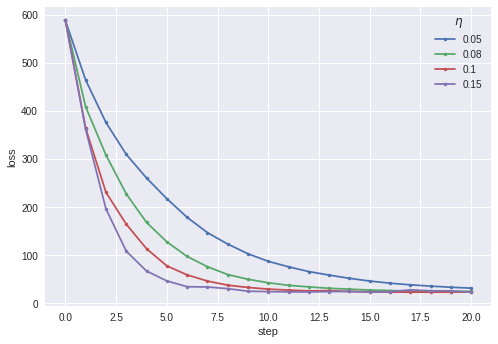

In [6]:
etas = [0.05, 0.08, 0.1, 0.15]  # Add 0.17 to see divergence
errors = []
BATCH_SIZE = 100

for e in etas:
    reset_vars()
    optimizer = tf.train.GradientDescentOptimizer(e)  # learning rate
    train = optimizer.minimize(loss)
    errors.append([sess.run(loss, feed_dict={x: Xs_train,
                                                y_label: y_train.reshape(-1, 1)})])
    for i in xrange(20):
        j = np.random.choice(len(y_train), BATCH_SIZE, replace=False)
        sess.run(train, feed_dict={x: Xs_train[j,:],
                                   y_label: y_train[j].reshape(-1,1)})
        errors[-1].append(sess.run(loss, feed_dict={x: Xs_train,
                                                    y_label: y_train.reshape(-1, 1)}))

plt.plot(np.array(errors).T, '.-')
plt.legend(etas, title=r'$\eta$')
plt.xlabel('step')
plt.ylabel('loss');

## Exercise

Adjust the learning rate and the batch size.  Can you get better performance?

## Exercise

The weight matrix $W$ contains information about how much each pixel contributes to each class.  Plot these contributions for several of the numbers.  Can you understand what the model was looking for in each case?

In [ ]:
# Existing code from notebook
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('/tmp/data', one_hot=True)

reset_tf()

N_PIXELS= 28 * 28
BATCH_SIZE = 100
LEARNING_RATE = 0.5

x = tf.placeholder(tf.float32, [None, N_PIXELS], name="pixels")
y_labels = tf.placeholder(tf.float32, [None, 10], name="labels")

W = tf.Variable(tf.zeros([N_PIXELS, 10]), name="weights")
b = tf.Variable(tf.zeros([10]), name="biases")
y = tf.matmul(x, W) + b

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, 
                                                              labels=y_labels))
train = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1),
                                           tf.argmax(y_labels, 1)),
                                  tf.float32))

reset_vars()

for i in range(1000):
    batch_x, batch_y = mnist.train.next_batch(BATCH_SIZE)
    sess.run(train,
             feed_dict={x: batch_x, y_labels: batch_y})
    if i % 100 == 0:
        print sess.run([loss, accuracy],
                       feed_dict={x: mnist.test.images, y_labels: mnist.test.labels})

In [ ]:
Ws = sess.run(W)

plt.figure(figsize=(8, 20))
for i in xrange(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(Ws[:, i].reshape(28, 28), cmap=plt.cm.RdBu, vmin=-0.5, vmax=0.5)
    plt.axis('off')

## Exercise

Iris classification.

In [ ]:
from sklearn import datasets

In [ ]:
iris = datasets.load_iris()

In [ ]:
iris_scaled = (iris.data - iris.data.mean(axis=0)) / iris.data.std(axis=0)

In [ ]:
reset_tf()

x = tf.placeholder(tf.float32, [None, 4], name="pixels")
y_labels = tf.placeholder(tf.int32, [None], name="labels")

y_encoded = tf.one_hot(y_labels, depth=3)

W = tf.Variable(tf.zeros([4, 3]), name="weights")
b = tf.Variable(tf.zeros([3]), name="biases")
y = tf.matmul(x, W) + b

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, 
                                                              labels=y_encoded))
train = tf.train.GradientDescentOptimizer(1).minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1),
                                           tf.argmax(y_encoded, 1)),
                                  tf.float32))

reset_vars()

for i in range(1000):
    sess.run(train, feed_dict={x: iris_scaled, y_labels: iris.target})
    if i % 100 == 0:
        print sess.run([loss, accuracy],
                       feed_dict={x: iris_scaled, y_labels: iris.target})

## Extra cell?

Comparing learning rates for logistic regression

etas = [0.05, 0.08, 0.1, 0.15, 0.2, 0.4, 1]  # Add 0.17 to see divergence
errors = []
BATCH_SIZE = 100

for e in etas:
    reset_vars()
    optimizer = tf.train.GradientDescentOptimizer(e)  # learning rate
    train = optimizer.minimize(loss)
    errors.append([sess.run(loss, feed_dict={x: Xs_train,
                                                y_label: yc_train.reshape(-1, 1)})])
    for i in xrange(50):
        j = np.random.choice(len(y_train), BATCH_SIZE, replace=False)
        sess.run(train, feed_dict={x: Xs_train[j,:],
                                   y_label: yc_train[j].reshape(-1,1)})
        errors[-1].append(sess.run(loss, feed_dict={x: Xs_train,
                                                    y_label: yc_train.reshape(-1, 1)}))

plt.plot(np.array(errors).T, '.-')
plt.legend(etas, title=r'$\eta$')
plt.xlabel('step')
plt.ylabel('loss');

*Copyright &copy; 2017 The Data Incubator.  All rights reserved.*